In [47]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 20

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)

'''
Origin of the graph
'''
depot_longitude       =  -79.383292
depot_latitude        =  43.652224

'''
Generate random coordinates
'''
longitude = np.random.normal(depot_longitude, 0.1, number_cities)
latitude  = np.random.normal(depot_latitude, 0.1, number_cities)


'''
Generate random demands per cities
'''
demands = np.random.randint(1, 11, number_cities-1)
demands = np.insert(demands,0,0)
print(demands)


'''
Insert coordinates in a matrix
'''
coords  =  []
k       =  0
for citie in range(len(cities)):
    coords.append([abs(round(longitude[k]*100000)), abs(round(latitude[k]*100000))])
    k += 1



print(coords)
df      = pd.DataFrame(coords, columns=['xcord', 'ycord'],    index=cities)
#df     = pd.DataFrame({"longitude":longitude,
#                       "latitude":latitude},  index=cities)

df_map = pd.DataFrame({"longitude":longitude,
                       "latitude":latitude,
                       "demand":demands},  index=cities)
print(df)
print("-------------------------------")
print(df_map)

[ 0  3  5  9  2  5  2  7  6  3  7 10  6  1  5  4  4 10  2  4]
[[7942511, 4372336], [7943526, 4371716], [7939152, 4375346], [7943204, 4371895], [7973704, 4366580], [7931798, 4381600], [7920516, 4360198], [7928649, 4352887], [7956748, 4383538], [7938678, 4360296], [7956023, 4376671], [7939849, 4368531], [7946570, 4357454], [7941265, 4355251], [7922378, 4361895], [7946194, 4357731], [7938352, 4374676], [7942660, 4371363], [7944316, 4366551], [7925694, 4386561]]
     xcord    ycord
A  7942511  4372336
B  7943526  4371716
C  7939152  4375346
D  7943204  4371895
E  7973704  4366580
F  7931798  4381600
G  7920516  4360198
H  7928649  4352887
I  7956748  4383538
J  7938678  4360296
K  7956023  4376671
L  7939849  4368531
M  7946570  4357454
N  7941265  4355251
O  7922378  4361895
P  7946194  4357731
Q  7938352  4374676
R  7942660  4371363
S  7944316  4366551
T  7925694  4386561
-------------------------------
   longitude   latitude  demand
A -79.425111  43.723364       0
B -79.435258  43.7171

In [46]:
longitude, latitude = coords.T                                   # We define that the first value of coords is X and the second is Y
plt.plot(longitude[0], latitude[0], c='r', marker='s')
plt.scatter(longitude[1:],latitude[1:], c='b')             # Put the x and y axis in pyplot
plt.show()                                  # Display the coordinates of the cities on an orthonormal coordinate system

AttributeError: 'list' object has no attribute 'T'

In [48]:
'''
Creation of the matrix of distances between cities
'''

matrix   = distance_matrix(df.values, df.values)
distance = pd.DataFrame(matrix, index=df.index, columns=df.index)
print(matrix)
print("--------------------------")
print(distance)

[[    0.          1189.38009064  4510.31939002   821.41950306
  31719.62775633 14162.98220715 25121.92407042 23883.43871807
  18115.65546703 12635.4061668  14190.36183471  4643.73438086
  15425.60874001 17130.37480617 22679.333544   15062.22141651
   4772.09398482   984.3424201   6060.05363013 22026.3958468 ]
 [ 1189.38009064     0.          5684.08092835   368.4087404
  30611.92872068 15337.51740015 25731.77848498 23997.00752177
  17736.43053154 12406.4299458  13443.47551789  4864.62269863
  14583.22940915 16619.51702066 23317.1598828  14237.22055037
   5960.8620182    935.18180051  5225.06698522 23202.46213228]
 [ 4510.31939002  5684.08092835     0.          5322.41533517
  35646.64724767  9653.69525104 24015.87808097 24793.54129607
  19409.4842796  15057.46246882 16922.95086561  6850.54990493
  19368.79934327 20205.7861515  21501.0808333  18970.45041637
   1043.50371346  5307.57505835 10198.96666334 17518.39002306]
 [  821.41950306   368.4087404   5322.41533517     0.
  30959.638644

In [29]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from time import time


class VPR:

    def __init__(self, n_trucks, dimension, capacity, demands, adj_matrix):
        self.n_trucks             =   n_trucks
        self.dimension            =   dimension
        self.capacity             =   capacity
        self.demands              =   demands
        self.adj_matrix           =   adj_matrix
        self.adj_matrix_sum       =   adj_matrix.sum()
        self.final_cost           =   self.adj_matrix_sum
        self.final_sol            =   None

        self.epochs               =   None
        self.n_ants               =   None
        self.alpha                =   None
        self.beta                 =   None
        self.rho                  =   None
        self.init_pheromone_value =   None
        self.pheromone_map        =   None
        self.raw_prob_matrix      =   None
        self.tabu                 =   None
        self.tabu_sum             =   None
        self.capacity_left        =   None

    def get_probality(self, raw_prob_list):
        prob_list = raw_prob_list/raw_prob_list.sum()
        return prob_list

    def get_next_vertex(self, pos):
        potential      =  deepcopy(self.tabu)
        potential_sum  =  self.tabu_sum
        while potential_sum < self.dimension:
            raw_prob_list  =  deepcopy(self.raw_prob_matrix[pos]) * potential
            next_vertex    =  np.random.choice(np.arange(0, self.dimension), p=self.get_probality(raw_prob_list))
            if self.demands[next_vertex] <= self.capacity_left:
                return next_vertex
            potential[next_vertex]  =  0
            potential_sum          +=  1
        return 0

    def local_update(self, i, j):
        self.pheromone_map[i, j]  += self.rho * self.init_pheromone_value / self.adj_matrix[i, j]
        self.pheromone_map[j, i]   = self.pheromone_map[i, j]
        self.raw_prob_matrix[i, j] = self.raw_prob_matrix[j, i] = (self.pheromone_map[i, j] ** self.alpha) * \
                                                                  ((1 / self.adj_matrix[i, j]) ** self.beta)

    def global_update(self, best_solution, best_cost):
        for one_path in best_solution:
            for i in range(len(one_path)-1):
                self.pheromone_map[one_path[i], one_path[i + 1]]    += self.rho * self.capacity / best_cost
                self.pheromone_map[one_path[i + 1], one_path[i]]    =  self.pheromone_map[one_path[i], one_path[i + 1]]
                self.raw_prob_matrix[one_path[i], one_path[i + 1]]  =  \
                    self.raw_prob_matrix[one_path[i + 1], one_path[i]] = \
                    (self.pheromone_map[one_path[i], one_path[i + 1]] ** self.alpha) * \
                    ((1 / self.adj_matrix[one_path[i], one_path[i + 1]]) ** self.beta)

    def get_cost(self, solution):
        current_cost = 0
        for i in range(len(solution) - 1):
            current_cost += self.adj_matrix[solution[i], solution[i + 1]]
        return current_cost

    def plot_function(self):
        box = {'facecolor': 'white',
               'edgecolor': 'black',
               'boxstyle': 'round'}
        plt.figure(figsize=(9.5, 6))
        plt.text(self.epochs - 18, self.show_epoch[4] - 60,
                 f'cost={round(self.final_cost, 2)}, \n'
                 f'epochs={self.epochs}, \n'
                 f'n_ants={self.n_ants}, \n'
                 f'alpha={self.alpha}, \n'
                 f'beta={self.beta}, \n'
                 f'p={self.rho}, \n'
                 f'init_ph={self.init_pheromone_value}',
                 bbox=box, color='black', fontsize=12)
        plt.plot(np.arange(self.epochs), self.show_cost, 'r')
        plt.plot(np.arange(self.epochs), self.show_epoch, 'k')
        plt.grid()
        plt.title(f'Fitness function for A-n{self.dimension}-k{self.n_trucks}', fontsize=18)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()

    def compute(self, epochs=100, n_ants=50, alpha=1.5, beta=0.3, rho=0.95, init_pheromone=1000):
        self.epochs                =  epochs
        self.n_ants                =  n_ants
        self.alpha                 =  alpha
        self.beta                  =  beta
        self.rho                   =  rho
        self.init_pheromone_value  =  init_pheromone
        self.pheromone_map         =  np.full(shape=(self.dimension, self.dimension), fill_value=self.init_pheromone_value)
        np.fill_diagonal(self.pheromone_map, 0)

        np.fill_diagonal(self.adj_matrix, 0.1)
        self.raw_prob_matrix = (self.pheromone_map ** self.alpha) * ((1 / self.adj_matrix) ** self.beta)
        np.fill_diagonal(self.adj_matrix, 0)

        self.show_epoch  =  []
        self.show_cost   =  []
        for epoch in range(self.epochs):
            time_s         = time()
            best_solution  = None
            best_cost      = self.adj_matrix_sum
            for ant in range(self.n_ants):
                current_state       =  0
                solutions           =  []
                one_path_solution   =  [0]
                self.capacity_left  =  self.capacity
                self.tabu           =  np.ones(self.dimension)
                self.tabu[0]        =  0
                self.tabu_sum       =  1
                while self.tabu_sum < self.dimension:
                    next_state = self.get_next_vertex(current_state)
                    if next_state == 0:
                        one_path_solution.append(0)
                        solutions.append(one_path_solution)
                        one_path_solution   =  [0]
                        current_state       =  0
                        self.capacity_left  =  self.capacity
                        continue
                    one_path_solution.append(next_state)
                    self.capacity_left -= self.demands[next_state]
                    self.local_update(current_state, next_state)
                    current_state             =  next_state
                    self.tabu[current_state]  =  0
                    self.tabu_sum            +=  1

                one_path_solution.append(0)
                solutions.append(one_path_solution)
                cost = sum([self.get_cost(sol) for sol in solutions])

                assert all(np.unique(np.hstack(solutions)) == np.arange(self.dimension))

                if cost < best_cost:
                    best_cost      =  cost
                    best_solution  =  solutions

            self.global_update(best_solution, best_cost)
            self.show_epoch.append(best_cost)
            if self.final_cost > best_cost:
                self.final_cost  =  best_cost
                self.final_sol   =  best_solution
                self.show_cost.append(self.final_cost)
            else:
                self.show_cost.append(self.show_cost[-1])
            # print(f'Epoch: {epoch} | time: {round(time() - time_s, 4)}| best cost: {best_cost}')

        self.final_sol = [(np.array(x) + 1).tolist() for x in self.final_sol]

In [49]:
car_number                       =  1
distance_ant                     =  matrix
distance_ant[distance_ant == 0]  =  np.inf

capacity                         =  50
dimension                        =  number_cities

adj_matrix                       =  matrix

case = VPR(car_number, dimension, capacity, demands, adj_matrix)
case.compute(epochs=100, n_ants=10, alpha=1, beta=1, rho=0.95, init_pheromone=1000)

print(f'Found solution:')
test534 = case.final_sol
display(case.final_sol)

Found solution:


[[1, 18, 2, 10, 8, 7, 15, 17, 6, 20, 3, 19, 1],
 [1, 4, 12, 16, 13, 14, 9, 11, 5, 1]]

In [31]:
plt.scatter(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:], y[1:])
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
i   = 0
  
for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        print("Couple : ", dot1, dot2)
        plt.plot([x[dot1], x[dot2]], [y[dot1], y[dot2]], c=col[(i) % len(col)])
    i += 1
    print("---------------------")
plt.show

NameError: name 'x' is not defined

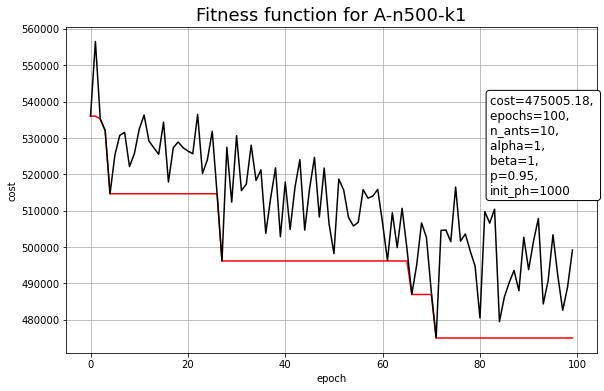

In [43]:
case.plot_function()

In [84]:
#import folium
#
##m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron", zoom_start=13)
#
#
#depot_longitude       =  -79.383292
#depot_latitude        =  43.652224
#customer_count        =  10
#
##coords_long_lat       = np.random.randint(low=[latitude_min, latitude_max], high=[longitude_max, latitude_max], size=(number_cities, 2))
#
#demand = np.random.randint(1, 11, customer_count-1)
#demand = np.insert(demand,0,0)
#print(demand)
#
#df_map = pd.DataFrame({"longitude":np.random.normal(depot_longitude, 0.008, customer_count),
#                       "latitude":np.random.normal(depot_latitude, 0.008, customer_count),
#                       "demand":demand})
#
#
#print(df_map)

In [56]:
import folium
m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron" , zoom_start=10)

for index, row in df_map.iterrows():
    icon_house = "circle"
    color      = "blue"
    if index == "A":
        icon_house = "home"
        color      = "red"
    popup_demand = "Demand: " + str(row['demand'])
    folium.Marker(location=[row['latitude'], row['longitude']], tooltip="click for more", popup = popup_demand, icon=folium.Icon(color=color ,icon=icon_house, prefix='fa')).add_to(m)
m

In [58]:
col = ['blue', 'green', 'red', 'pink', 'orange', 'yellow', 'black', 'brown']
i   = 0


for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        dot1_loc = df_map.iloc[dot1]
        dot2_loc = df_map.iloc[dot2]
        

        line = [(dot1_loc['latitude'],dot1_loc['longitude']), (dot2_loc['latitude'],dot2_loc['longitude'])]
        
        folium.PolyLine(line,
                color=col[(i) % len(col)],
                weight=5,
                opacity=0.8).add_to(m)
    i += 1

m